# FF3 Model

In [41]:
import yfinance as yf
import pandas as pd
from datetime import datetime, date, timedelta
import numpy as np
import statsmodels.formula.api as sma
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

In [21]:
def get_total_return(ticker, start_date, end_date):
    # Fetch the historical data for the specified stock and date range
    stock_data = yf.download(ticker, start=start_date, end=end_date)

    # Calculate the total return
    initial_price = stock_data['Open'].iloc[0]
    final_price = stock_data['Open'].iloc[-1]
    daily_returns = stock_data['Open'].pct_change()

    total_return = daily_returns.mean() * (len(daily_returns) - 1)*100

    # print("Total return from", start_date, "to", end_date, "for", ticker, ":", total_return, "%")
    return total_return

def get_price(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)

    # Calculate the total return
    initial_price = stock_data['Open'].iloc[0]
    return initial_price

def get_price_spent(ticker, n, start_date):
    end_date = start_date + timedelta(days=1)
    stock_data = yf.download(ticker, start=start_date.date(), end=end_date.date())

    return (stock_data['Open']*n).values[0]

def get_sd(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date.date(), end=end_date.date())
    # Calculate the total return
    days = len(stock_data) - 1
    stddev_open = stock_data['Open'].pct_change().std()*(days**0.5)
    # stddev_open = stddev_open/stock_data['Open'][0]
    return stddev_open

def get_beta(ticker, start_date, end_date):
    x = yf.Ticker(ticker)
    if x.info.get('beta') == None:
        return x.info.get('beta3Year')
    return x.info.get('beta')

def get_ff3_regresssion(ticker, start_date, end_date):
        pass

def get_open_prices(tickers, start_date, end_date):
    stock_data = yf.download(tickers, start=start_date, end=end_date)
    daily_returns = stock_data['Open'].pct_change()
    return daily_returns

In [22]:
initial_cash = 100000
tickers = ["SPY", "MCD", "NVDA", "EWH"]
counts = [90, 30, 20, 2000]
start_date = datetime.strptime("2024-01-31", "%Y-%m-%d")
end_date = datetime.strptime("2024-03-22", "%Y-%m-%d")
cost = []
total_return = []
std = []
beta = []
prices = []

for i in range(len(tickers)):
    total_return.append(get_total_return(tickers[i], start_date, end_date))
    cost.append(get_price_spent(tickers[i], counts[i], start_date))
    std.append(get_sd(tickers[i], start_date, end_date))
    beta.append(get_beta(tickers[i], start_date, end_date))
    prices.append(get_price(tickers[i], start_date, end_date))

total_cost = 0
for i in cost:
    total_cost += i
print(total_cost)

weights = []
for i in cost:
    weights.append(i/total_cost)


portfolio = pd.DataFrame({'Name': tickers, "Num of Stocks": counts, "Price": prices, "Initial Cost": cost, "Total Return": total_return, "Weight": weights, "Std Dev": std, "Beta": beta})
# pd.options.display.float_format = "{:,.2f}".format

# portfolio return
portfolio_return = 0
for i, row in portfolio.iterrows():
    portfolio_return += row["Total Return"] * row["Weight"]


print(portfolio)

print("Portfolio Return:", portfolio_return)

# portfolio standard deviation
df = yf.download(tickers, start=start_date, end=end_date).Open.pct_change()
df = df[["SPY", "MCD", "NVDA", "EWH"]]
df = df.iloc[1:]

cov = df.cov()
multiple = pd.DataFrame([[35,35,35,34],[35,35,35,34], [35,35,35,34], [34,34,34,34]], ["SPY", "MCD", "NVDA", "EWH"], ["SPY", "MCD", "NVDA", "EWH"])
# print(multiple)
cov = cov.mul(multiple)
print(cov)

weights = np.array(weights)
portfolio_risk = np.sqrt(np.dot(weights, np.dot(weights.T, cov)))
print("portfolio sd", portfolio_risk)

# portfolio beta
portfolio_beta = (weights*beta).sum()
print("portfolio beta:", portfolio_beta)

# risk free rate assume it is us 3 month t bill
rf_df = yf.download("^IRX", start=start_date, end=end_date)
rf_df = rf_df["Open"]
if hasattr(rf_df.columns, "nlevels") and rf_df.columns.nlevels > 1:
    # try to find '^IRX' in any column level and extract it
    extracted = None
    for lvl in range(rf_df.columns.nlevels):
        if '^IRX' in rf_df.columns.get_level_values(lvl):
            rf_df = rf_df.xs('^IRX', axis=1, level=lvl)
            extracted = True
            break
    if not extracted:
        rf_df = rf_df.iloc[:, 0]  # fallback to first column
else:
    rf_df = rf_df['^IRX'] if '^IRX' in rf_df.columns else rf_df.iloc[:, 0]
# print("rf:", rf_df.mean()['Open'])
rf_df.name = "rf"
# convert rf to daily values
rf_df = (1 + rf_df)**(1/360)-1
rf_df

/var/folders/zk/99phrd0d2fs5xjbc622wn4_h0000gn/T/ipykernel_12060/507010731.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed
/var/folders/zk/99phrd0d2fs5xjbc622wn4_h0000gn/T/ipykernel_12060/507010731.py:24: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(ticker, start=start_date.date(), end=end_date.date())
[*********************100%***********************]  1 of 1 completed
/var/folders/zk/99phrd0d2fs5xjbc622wn4_h0000gn/T/ipykernel_12060/507010731.py:29: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(ticker, start=start_date.date(), end=end_date.date())
[*********************100%***********************]  1 of 1 completed
/var/folders/zk/99phrd0d2fs5xjbc622wn4_h0000gn/T/ipykernel_12060/507010731.py:16: Fut

[82228.52151719]
   Name  Num of Stocks                                              Price  \
0   SPY             90  Ticker
SPY    478.241113
Name: 2024-01-31 00:0...   
1   MCD             30  Ticker
MCD    284.008187
Name: 2024-01-31 00:0...   
2  NVDA             20  Ticker
NVDA    61.409208
Name: 2024-01-31 00:0...   
3   EWH           2000  Ticker
EWH    14.719194
Name: 2024-01-31 00:00...   

           Initial Cost                             Total Return  \
0   [43041.70292606918]    Ticker
SPY    7.274792
dtype: float64   
1   [8520.245606062403]    Ticker
MCD   -3.117723
dtype: float64   
2  [1228.1841605916177]  Ticker
NVDA    43.453495
dtype: float64   
3   [29438.38882446289]    Ticker
EWH    3.143096
dtype: float64   

                   Weight                                 Std Dev   Beta  
0    [0.5234400683839766]    Ticker
SPY    0.04136
dtype: float64  1.000  
1   [0.10361667033356105]   Ticker
MCD    0.070341
dtype: float64  0.495  
2  [0.014936230615978208]  Tick

Date
2024-01-31    0.005083
2024-02-01    0.005079
2024-02-02    0.005081
2024-02-05    0.005085
2024-02-06    0.005092
2024-02-07    0.005090
2024-02-08    0.005088
2024-02-09    0.005089
2024-02-12    0.005088
2024-02-13    0.005092
2024-02-14    0.005095
2024-02-15    0.005088
2024-02-16    0.005087
2024-02-20    0.005090
2024-02-21    0.005092
2024-02-22    0.005095
2024-02-23    0.005098
2024-02-26    0.005100
2024-02-27    0.005101
2024-02-28    0.005098
2024-02-29    0.005096
2024-03-01    0.005089
2024-03-04    0.005089
2024-03-05    0.005096
2024-03-06    0.005095
2024-03-07    0.005094
2024-03-08    0.005091
2024-03-11    0.005096
2024-03-12    0.005099
2024-03-13    0.005101
2024-03-14    0.005098
2024-03-15    0.005097
2024-03-18    0.005098
2024-03-19    0.005097
2024-03-20    0.005099
2024-03-21    0.005092
Name: rf, dtype: float64

In [23]:
# SMB
small = ["IWN", "XSLV", "IWO"]
big =  ["DIA", "RSP", "QQQ"]
start_date = datetime.strptime("2024-01-31", "%Y-%m-%d")
end_date = datetime.strptime("2024-03-22", "%Y-%m-%d")


# average returns for small
s = yf.download(small, start=start_date, end=end_date)
days = len(s)
sm = s.Open.pct_change()
sm["mean"] = sm.mean(axis=1)
# print(sm)

# average returns for big
b = yf.download(big,  start=start_date, end=end_date)
bm = b.Open.pct_change()
bm["mean"] = bm.mean(axis=1)
# print(bm)

smb = (sm-bm)["mean"].dropna()
smb.name = "smb"
# print("SMB", smb)

# print("sum:", smb.sum())

# HML
value = ["SPYV", "FVAL"]
growth = ["QQQ", "VUG"]
start_date = datetime.strptime("2024-01-31", "%Y-%m-%d")
end_date = datetime.strptime("2024-03-22", "%Y-%m-%d")


# average returns for small
v = yf.download(value, start=start_date, end=end_date)
days = len(v)
vm = v.Open.pct_change()
vm["mean"] = vm.mean(axis=1)

# average returns for big
g = yf.download(growth,  start=start_date, end=end_date)
gm = g.Open.pct_change()
gm["mean"] = gm.mean(axis=1)

hml = (vm - gm)["mean"].dropna()
hml.name = "hml"
# print("HML", hml)
# print("sum:", hml.sum())


/var/folders/zk/99phrd0d2fs5xjbc622wn4_h0000gn/T/ipykernel_12060/3727577439.py:9: FutureWarning: YF.download() has changed argument auto_adjust default to True
  s = yf.download(small, start=start_date, end=end_date)
[                       0%                       ]

[*********************100%***********************]  3 of 3 completed
/var/folders/zk/99phrd0d2fs5xjbc622wn4_h0000gn/T/ipykernel_12060/3727577439.py:16: FutureWarning: YF.download() has changed argument auto_adjust default to True
  b = yf.download(big,  start=start_date, end=end_date)
[*********************100%***********************]  3 of 3 completed
/var/folders/zk/99phrd0d2fs5xjbc622wn4_h0000gn/T/ipykernel_12060/3727577439.py:35: FutureWarning: YF.download() has changed argument auto_adjust default to True
  v = yf.download(value, start=start_date, end=end_date)
[*********************100%***********************]  2 of 2 completed
/var/folders/zk/99phrd0d2fs5xjbc622wn4_h0000gn/T/ipykernel_12060/3727577439.py:41: FutureWarning: YF.download() has changed argument auto_adjust default to True
  g = yf.download(growth,  start=start_date, end=end_date)
[*********************100%***********************]  2 of 2 completed


In [35]:
# merge all the tickers daily open price with the smb and hml
to_calc = get_open_prices(tickers, start_date, end_date).merge(rf_df, on="Date")
to_calc = to_calc.merge(smb, on="Date")
to_calc = to_calc.merge(hml, on="Date")
to_calc["Rm"] = to_calc["SPY"] - to_calc["rf"]
print(to_calc)

# Regressions to compute FF5 alphas and corresponding t-stats.
a1, a3, a5, am = [],[],[],[]
rsquared1, rsquared3, rsquared5, rsquaredm = [],[],[],[]
lower1, lower3, lower5, lowerm = [],[],[],[]
upper1, upper3, upper5, upperm = [],[],[],[]
s = []
models = {}
for i in portfolio["Name"]:
    if len(df[i].dropna()) !=0:
        Rm = to_calc["Rm"]
        s.append(i)

        reg = sma.ols("%s ~ Rm" %i, data=to_calc).fit()
        ff3 = sma.ols("%s ~ Rm + smb + hml" %i, data=to_calc).fit()
        models[i] = ff3
        # ff5 = sma.ols("%se ~ Mkt_RF + SMB + HML + rmw + cma" %i, data=df).fit()
        # mom = sma.ols("%se ~ Mkt_RF + SMB + HML + rmw + cma + Momentum" %i, data=df).fit()

        # a1.append(reg.params[0])
        # lower1.append(reg.conf_int().T["Intercept"][0])
        # upper1.append(reg.conf_int().T["Intercept"][1])

        a3.append(ff3.params[0])
        lower3.append(ff3.conf_int().T["Intercept"][0])
        upper3.append(ff3.conf_int().T["Intercept"][1])

        # a5.append(ff5.params[0])
        # lower5.append(ff5.conf_int().T["Intercept"][0])
        # upper5.append(ff5.conf_int().T["Intercept"][1])

        # am.append(mom.params[0])
        # lowerm.append(mom.conf_int().T["Intercept"][0])
        # upperm.append(mom.conf_int().T["Intercept"][1])

        rsquared1.append(reg.rsquared_adj)
        rsquared3.append(ff3.rsquared_adj)
        # rsquared5.append(ff5.rsquared_adj)
        # rsquaredm.append(mom.rsquared_adj)
    else:
        pass

result = pd.DataFrame()
result["stock"] = s
# result["a_capm"] = a1
# result["lower_capm"] = lower1
# result["upper_capm"] = upper1
# result["r2_capm"] = rsquared1

result["a_ff3"] = a3
result["lower_ff3"] = lower3
result["upper_ff3"] = upper3
result["r2_ff3"] = rsquared3

# result["a_ff5"] = a5
# result["lower_ff5"] = lower5
# result["upper_ff5"] = upper5
# result["r2_ff5"] = rsquared5

# result["a_mom"] = am
# result["lower_mom"] = lowerm
# result["upper_mom"] = upperm
# result["r2_mom"] = rsquaredm

/var/folders/zk/99phrd0d2fs5xjbc622wn4_h0000gn/T/ipykernel_12060/507010731.py:46: FutureWarning: YF.download() has changed argument auto_adjust default to True
  stock_data = yf.download(tickers, start=start_date, end=end_date)
[                       0%                       ]

[*********************100%***********************]  4 of 4 completed

                     EWH       MCD      NVDA       SPY        rf       smb  \
Date                                                                         
2024-02-01  7.015215e-03 -0.014194  0.010742 -0.008166  0.005079 -0.005854   
2024-02-02 -1.266624e-02  0.014982  0.030177  0.010358  0.005081 -0.011449   
2024-02-05  4.490081e-03 -0.030601  0.066449  0.008271  0.005085 -0.009626   
2024-02-06  2.298859e-02 -0.014076  0.020594 -0.000365  0.005092 -0.004309   
2024-02-07  6.242177e-03  0.007351 -0.018828  0.005613  0.005090  0.005129   
2024-02-08 -5.583127e-03  0.004034  0.025688  0.003647  0.005088 -0.007440   
2024-02-09 -4.366871e-03  0.020790  0.006551  0.001486  0.005089  0.015589   
2024-02-12  1.065163e-02 -0.010782  0.029305  0.004671  0.005088  0.010410   
2024-02-13 -6.819493e-03 -0.001280 -0.030303 -0.013249  0.005092 -0.005614   
2024-02-14  3.745240e-03 -0.004539  0.039801  0.004570  0.005095  0.003184   
2024-02-15  1.865634e-03  0.002019  0.009111  0.005032  0.005088


/var/folders/zk/99phrd0d2fs5xjbc622wn4_h0000gn/T/ipykernel_12060/1987100201.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  a3.append(ff3.params[0])
/var/folders/zk/99phrd0d2fs5xjbc622wn4_h0000gn/T/ipykernel_12060/1987100201.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  a3.append(ff3.params[0])
/var/folders/zk/99phrd0d2fs5xjbc622wn4_h0000gn/T/ipykernel_12060/1987100201.py:30: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


In [32]:
for i in models.keys():
    print(i)
    print(models[i].summary())

SPY
                            OLS Regression Results                            
Dep. Variable:                    SPY   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.839e+07
Date:                Sun, 28 Sep 2025   Prob (F-statistic):           6.00e-97
Time:                        10:58:37   Log-Likelihood:                 376.41
No. Observations:                  35   AIC:                            -744.8
Df Residuals:                      31   BIC:                            -738.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0051   1.17e-06   4362.985     

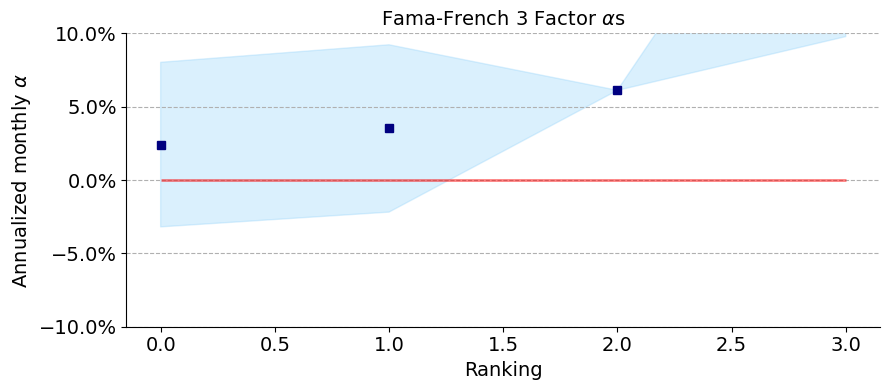

In [44]:
# FF3 alphas plots with confidence intervals
t = result[["stock","a_ff3","lower_ff3","upper_ff3"]]
t = t.sort_values(by=["a_ff3"]).reset_index().drop(columns=["index"])

fig, ax = plt.subplots(figsize=(9,4))

ax.plot(t.index, t.a_ff3*12*100, color="navy", marker="s", ls="")
ax.fill_between(t.index, t.lower_ff3*12*100, t.upper_ff3*12*100, color="lightskyblue", alpha=0.3)
ax.hlines(0,0,len(t)-1, color="red", lw=2, alpha=0.5)

ax.tick_params(axis = "both", labelsize = 14)
ax.set_xlabel("Ranking",fontsize=14)
ax.set_ylabel("Annualized monthly $\\alpha$",fontsize=14)
ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=1))
ax.grid(axis="y",linestyle="--")
ax.set_title("Fama-French 3 Factor $\\alpha$s", fontsize=14)
plt.ylim([-10,10])
sns.despine()
plt.tight_layout()